In [1]:
import os
from skimage import img_as_uint
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu, threshold_local
from skimage import morphology
from sklearn.cluster import DBSCAN
from scipy.ndimage.morphology import binary_fill_holes

In [2]:
def binarize(im):
    local_thresh = threshold_local(im, method='mean', block_size=101, offset=0.025)
    binary_local = im < local_thresh

    return morphology.remove_small_objects(binary_local, min_size=500)

In [3]:
def ImageToFeatures(img):
    data = []
    for i, row in enumerate(img):
        for j, val in enumerate(row):
            if val:
                data.append([j, i])
    return np.array(data)

def FeaturesToImage(fts, width, height, correction=False):
    minx = min(fts[:, 0])
    miny = min(fts[:, 1])

    maxx = max(fts[:, 0])
    maxy = max(fts[:, 1])
    
    image = np.zeros((width, height))
    
    if correction:
        ft_width = maxx-minx
        ft_height = maxy-miny
        if ft_width > width or ft_height > height:
            return np.zeros((width, height))
        indent_width = int((width-ft_width)/2)
        indent_height = int((height-ft_height)/2)
        for x, y in fts:
            image[y-miny+indent_height, x-minx+indent_width] = 1
    else:
        for x, y in fts:
            image[y, x] = 1
            
    return image

In [4]:
def clusterize(pixels):
    scan = DBSCAN(eps=30, min_samples=1000)
    return scan.fit_predict(pixels)

In [5]:
def n_clusters(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)

In [6]:
notch_size=650
def prepare(image):
    pixels = ImageToFeatures(image)
    
    labels = clusterize(pixels)
    
    n_clt = n_clusters(labels)
    
    clusters = [np.where(labels==i)[0] for i in range(n_clt)]
    
    notches=[]
    for cluster in clusters:
        notches.append([pixels[ix] for ix in cluster])
    notches = np.array(notches)
    
    data=list(map(lambda x: FeaturesToImage(np.array(x), width=notch_size, height=notch_size, correction=True), notches))
    data_src=list(map(lambda x: FeaturesToImage(np.array(x), width=image.shape[0], height=image.shape[1]), notches))
    
    data_prep = []
    for dt in data:
        if dt != None:
            data_prep.append(dt.reshape(notch_size**2))
        else:
            data_prep.append(np.zeros(notch_size**2))
            
    return (data, data_src, data_prep)

In [116]:
fld = os.getcwd() + '\\photo1\\'
#image = io.imread(fld + '20180810_0056.jpg', as_gray=True)
image = io.imread(fld + '20180810_0089.jpg', as_gray=True)

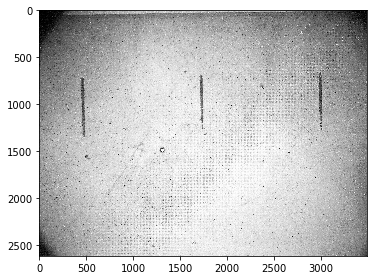

In [117]:
io.imshow(image)
plt.show()

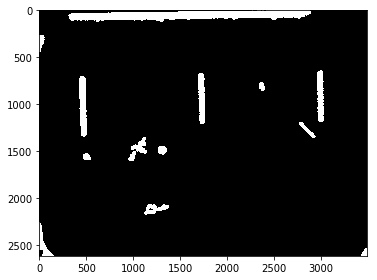

Wall time: 6.63 s


In [118]:
%%time
from skimage.morphology import dilation, erosion
from skimage.morphology import *

def binarize(im):
    local_thresh = threshold_local(im, method='mean', block_size=151, offset=0.055)
    binary_local = im < local_thresh
    cleaned = morphology.remove_small_objects(binary_local, min_size=1000)
    
    strel = disk(16)    
    cleaned = binary_dilation(cleaned, strel)
    
    return cleaned

bimage = binarize(image)
io.imshow(bimage)
plt.show()

In [121]:
lb, n = label(bimage, return_num=True)

In [122]:
n

14

In [28]:
data, data_src, data_prep = prepare(bimage)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [30]:
len(data)

33

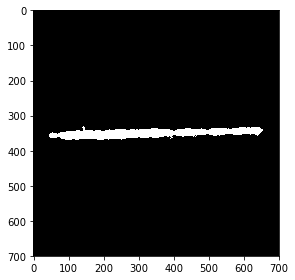

In [48]:
io.imshow(data[11])
plt.show()

D:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


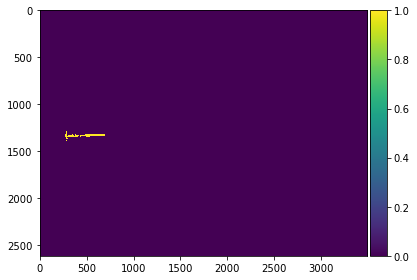

In [49]:
io.imshow(data_src[12])
plt.show()

In [33]:
data_src[5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])